# MovieLens Dataset

Лаботоратория по искусственному интеллекту, Сбербанк. 

Авторы: [Борис Шминке](<mailto:Shminke.B.A@omega.sbrf.ru>), [Роза Айсина](<mailto:Aysina.R.M@omega.sbrf.ru>). 

О чем: применение рекомендательных систем к датасету историй. Схема разбиения - делим лог на две рандомные части.

Ссылка на данные: https://grouplens.org/datasets/movielens/20m/

## Содержание

1. [Импорты, создание спарк-сессии](#intro)
2. [Подготовка данных](#data-preparator)
3. [Рекомендатель на основе популярности](#popular-recommender)
3.1. [Запуск single модели](#popular-recommender-single)
3.2. [Подбор гиперпараметров](#popular-recommender-scenario)
4. [Рекомендатель на основе k-NN для объектов](#knn-recommender)
4.1. [Запуск single модели](#knn-recommender-single)
4.2. [Подбор гиперпараметров](#knn-recommender-scenario)

### Импорты, создание спарк-сессии <a name='intro'></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
import re
import sys
from collections import Counter
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql.types import DoubleType, StringType, StructType, StructField, TimestampType

from sklearn.feature_extraction.text import CountVectorizer

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.metrics.metrics import Metrics
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.models.knn_recommender import KNNRecommender
from sponge_bob_magic.scenarios.knn_scenario import KNNScenario
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.validation_schemes import ValidationSchemes

In [5]:
# отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [6]:
spark_memory = "200g"
spark_cores = "*"
user_home = "/datascc/aysina-rm"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .config('spark.local.dir', os.path.join(user_home, "tmp"))
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

spark

In [7]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [8]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Подготовка данных <a name='data-preparator'></a>

In [9]:
path_log = '../data/movielens/ml-20m/ratings.csv'

In [10]:
dp = DataPreparator(spark)

In [13]:
df = dp.transform_log(
    path_log,
    format_type='csv',
    columns_names={
        'user_id': 'userId', 
        'item_id': 'movieId',
    },
    date_format=None,
    header=True
)

In [14]:
df.show(3)

+-------+-------+-------------------+----------+---------+
|user_id|item_id|          timestamp|   context|relevance|
+-------+-------+-------------------+----------+---------+
|      1|      2|1999-05-01 00:00:00|no_context|      1.0|
|      1|     29|1999-05-01 00:00:00|no_context|      1.0|
|      1|     32|1999-05-01 00:00:00|no_context|      1.0|
+-------+-------+-------------------+----------+---------+
only showing top 3 rows



In [15]:
df.count()

20000263

In [16]:
df.agg(*(sf.countDistinct(sf.col(c)).alias(c) for c in df.columns)).show()

+-------+-------+---------+-------+---------+
|user_id|item_id|timestamp|context|relevance|
+-------+-------+---------+-------+---------+
| 138493|  26744|        1|      1|        1|
+-------+-------+---------+-------+---------+



In [17]:
df.agg(sf.min(sf.col("timestamp")), sf.max(sf.col("timestamp"))).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|1999-05-01 00:00:00|1999-05-01 00:00:00|
+-------------------+-------------------+



In [18]:
df_short = df.limit(1000).cache()

## Рекомендатель на основе популярности (popularity based recommender) <a name='popular-recommender'></a>

### Запуск single модели <a name='popular-recommender-single'></a>

In [19]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_randomly(
    df, test_size=0.2,
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(16000821, 16000821, 3998437)

In [20]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [21]:
%%time

pr.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

07-Nov-19 15:40:13, root, DEBUG: Проверка датафреймов
07-Nov-19 15:40:18, root, DEBUG: Предварительная стадия обучения (pre-fit)
07-Nov-19 15:40:21, root, DEBUG: Среднее количество items у каждого user: 116.0
07-Nov-19 15:40:21, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 20.3 ms, sys: 7.53 ms, total: 27.8 ms
Wall time: 8.29 s


In [22]:
%%time

recs = pr.predict(
    k=100,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

07-Nov-19 15:40:21, root, DEBUG: Проверка датафреймов
07-Nov-19 15:40:43, root, DEBUG: Количество items после фильтрации: 216


CPU times: user 35 ms, sys: 10.9 ms, total: 45.9 ms
Wall time: 22.5 s


In [23]:
recs.show(5)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|    296| 100010|no_context|0.003362889941709866|
|    356| 100010|no_context|0.003297643289678...|
|    593| 100010|no_context|0.003176149523827...|
|    318| 100010|no_context|0.003164400126718...|
|    480| 100010|no_context|0.002993783881464582|
+-------+-------+----------+--------------------+
only showing top 5 rows



In [24]:
%%time

metric = Metrics.hit_rate_at_k(recs, df, k=100)
metric

CPU times: user 11.9 ms, sys: 6.83 ms, total: 18.8 ms
Wall time: 33.8 s


0.8775699042882341

### Подбор гиперпараметров в популярной модели <a name='popular-recommender-scenario'></a>

Популярность объекта определяется как: 

$$ popularity(i) = \dfrac{N_i + \alpha}{N + \beta}, $$

где $ N_i $ &mdash; количество пользователей, у которых было взаимодействие с данным объектом $ i $, 
$ N $ &mdash; общее количество пользователей, которые как провзаимодействовали с объектом, так и нет,
$ \alpha, \beta \in [0, \infty) $ &mdash; параметры модели. 

Эвристика: размуным пределом для параметров $ \alpha $ и $ \beta $ может стать среднее значение количества пользователей $ N_i $, которые провзаимодействовали с объектами.

In [25]:
avg_num_users = (
    df
    .select('user_id', 'item_id')
    .groupBy('item_id')
    .count()
    .select(sf.mean(sf.col('count')).alias('mean'))
    .collect()[0]['mean']
)

avg_num_users

747.8411232425965

In [26]:
popular_scenario = PopularScenario(spark)
popular_scenario.seed = 9876

In [32]:
%%time

popular_params_grid = {
    'alpha': (0, 1000), 
    'beta': (0, 1000)
}

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=15, 
    n_jobs=1,
    how_to_split='randomly'
)

best_params

07-Nov-19 15:50:13, root, DEBUG: Деление на трейн и тест
07-Nov-19 15:50:13, root, DEBUG: Длина трейна и теста: (13999374, 5999156)
07-Nov-19 15:50:14, root, DEBUG: Количество юзеров в трейне и тесте: 138493, 138483
07-Nov-19 15:50:15, root, DEBUG: Количество айтемов в трейне и тесте: 25316, 20502
07-Nov-19 15:50:15, root, DEBUG: Популярная модель: полное обучение
07-Nov-19 15:50:15, root, DEBUG: Проверка датафреймов
07-Nov-19 15:50:16, root, DEBUG: Предварительная стадия обучения (pre-fit)
07-Nov-19 15:50:17, root, DEBUG: Среднее количество items у каждого user: 102.0
07-Nov-19 15:50:17, root, DEBUG: Основная стадия обучения (fit)
07-Nov-19 15:50:17, root, DEBUG: -------------
07-Nov-19 15:50:17, root, DEBUG: Начало оптимизации параметров
07-Nov-19 15:50:17, root, DEBUG: -- Параметры: {'alpha': 570, 'beta': 472}
07-Nov-19 15:50:17, root, DEBUG: -- Предикт модели в оптимизации
07-Nov-19 15:50:17, root, DEBUG: Проверка датафреймов
07-Nov-19 15:50:23, root, DEBUG: Количество items после 

07-Nov-19 16:02:30, root, DEBUG: Проверка датафреймов
07-Nov-19 16:02:37, root, DEBUG: Количество items после фильтрации: 117
07-Nov-19 16:03:06, root, DEBUG: -- Длина рекомендаций: 2077245
07-Nov-19 16:03:06, root, DEBUG: -- Подсчет метрики в оптимизации
07-Nov-19 16:03:38, root, DEBUG: -- Метрика: (0.7479618436920055, 0.22297566143306646)
[I 2019-11-07 16:03:38,219] Finished trial#11 resulted in value: 0.7479618436920055. Current best value is 0.7479618436920055 with parameters: {'alpha': 570, 'beta': 472}.
07-Nov-19 16:03:38, root, DEBUG: -- Параметры: {'alpha': 94, 'beta': 351}
07-Nov-19 16:03:38, root, DEBUG: -- Предикт модели в оптимизации
07-Nov-19 16:03:38, root, DEBUG: Проверка датафреймов
07-Nov-19 16:03:44, root, DEBUG: Количество items после фильтрации: 117
07-Nov-19 16:04:13, root, DEBUG: -- Длина рекомендаций: 2077245
07-Nov-19 16:04:13, root, DEBUG: -- Подсчет метрики в оптимизации
07-Nov-19 16:04:44, root, DEBUG: -- Метрика: (0.7479618436920055, 0.22297566143306655)
[I 

CPU times: user 1.93 s, sys: 318 ms, total: 2.25 s
Wall time: 17min 18s


{'alpha': 570, 'beta': 472}

In [33]:
results = pd.concat([popular_scenario.study.trials_dataframe(), results], axis=0)

results

number                state     value             datetime_start  \
                                                                      
0   0      TrialState.COMPLETE  0.747962 2019-11-07 15:50:17.042254   
1   1      TrialState.COMPLETE  0.747962 2019-11-07 15:51:22.360283   
2   2      TrialState.COMPLETE  0.747962 2019-11-07 15:52:27.343925   
3   3      TrialState.COMPLETE  0.747962 2019-11-07 15:53:32.432047   
4   4      TrialState.COMPLETE  0.747962 2019-11-07 15:54:39.169526   
5   5      TrialState.COMPLETE  0.747962 2019-11-07 15:55:45.498017   
6   6      TrialState.COMPLETE  0.747962 2019-11-07 15:56:50.733428   
7   7      TrialState.COMPLETE  0.747962 2019-11-07 15:57:56.792478   
8   8      TrialState.COMPLETE  0.747962 2019-11-07 15:59:07.904521   
9   9      TrialState.COMPLETE  0.747962 2019-11-07 16:00:16.647104   
10  10     TrialState.COMPLETE  0.747962 2019-11-07 16:01:22.977891   
11  11     TrialState.COMPLETE  0.747962 2019-11-07 16:02:30.862845   
12  12     TrialState.COMPLETE  0.747962 2019-11-07 16:03:38.220616   
13  13     TrialState.COMPLETE  0.747962 2019-11-07 16:04:44.486244   
14  14     TrialState.COMPLETE  0.747962 2019-11-07 16:06:14.643353   
0   0      TrialState.COMPLETE  0.747962 2019-11-07 15:46:55.976881   
0   0      TrialState.COMPLETE  0.747962 2019-11-07 15:43:08.742889   

            datetime_complete params      user_attrs system_attrs  
                               alpha beta     nDCG@k      _number  
0  2019-11-07 15:51:22.359295  570    472  0.222976   0            
1  2019-11-07 15:52:27.342971  128    348  0.222976   1            
2  2019-11-07 15:53:32.430730  282    787  0.222976   2            
3  2019-11-07 15:54:39.167794  694    172  0.222976   3            
4  2019-11-07 15:55:45.496715  177    927  0.222976   4            
5  2019-11-07 15:56:50.730861  730    888  0.222976   5            
6  2019-11-07 15:57:56.790347  836    201  0.222976   6            
7  2019-11-07 15:59:07.902089  297    18   0.222976   7            
8  2019-11-07 16:00:16.645009  351    606  0.222976   8            
9  2019-11-07 16:01:22.976035  592    746  0.222976   9            
10 2019-11-07 16:02:30.860045  883    558  0.222976   10           
11 2019-11-07 16:03:38.218229  946    563  0.222976   11           
12 2019-11-07 16:04:44.483280  94     351  0.222976   12           
13 2019-11-07 16:06:14.640113  771    72   0.222976   13           
14 2019-11-07 16:07:32.090824  560    818  0.222976   14           
0  2019-11-07 15:48:03.376156  336    172  0.222976   0            
0  2019-11-07 15:44:26.813105  1      0    0.222976   0

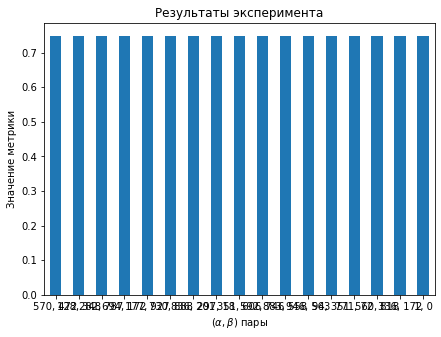

In [35]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [36]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

07-Nov-19 16:15:26, root, DEBUG: Проверка датафреймов
07-Nov-19 16:15:27, root, DEBUG: Предварительная стадия обучения (pre-fit)
07-Nov-19 16:15:29, root, DEBUG: Среднее количество items у каждого user: 145.0
07-Nov-19 16:15:29, root, DEBUG: Основная стадия обучения (fit)
07-Nov-19 16:15:29, root, DEBUG: Проверка датафреймов
07-Nov-19 16:15:29, root, DEBUG: Выделение дефолтных юзеров
07-Nov-19 16:15:29, root, DEBUG: Выделение дефолтных айтемов
07-Nov-19 16:15:39, root, DEBUG: Количество items после фильтрации: 155


CPU times: user 42.3 ms, sys: 11.3 ms, total: 53.6 ms
Wall time: 12.2 s


In [37]:
best_recs.show(10)

+-------+-------+----------+--------------------+
|item_id|user_id|   context|           relevance|
+-------+-------+----------+--------------------+
|    296| 100010|no_context|0.003393875275083...|
|    356| 100010|no_context|0.003336977366081...|
|    318| 100010|no_context|0.003196682521917...|
|    593| 100010|no_context|0.003193332645025...|
|    480| 100010|no_context|0.003014139230383...|
|    260| 100010|no_context|0.002753498808918...|
|    110| 100010|no_context|0.002716850155756776|
|    589| 100010|no_context|0.002640602957841...|
|   2571| 100010|no_context|0.002595104629904851|
|    527| 100010|no_context|0.002531106981818418|
+-------+-------+----------+--------------------+
only showing top 10 rows



## Рекомендатель на основе k-NN для объектов (item k-NN based recommender) <a name='knn-recommender'></a>

### Запуск single модели <a name='knn-recommender-single'></a>

In [19]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_randomly(
    df, test_size=0.2,
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(16002620, 16002620, 3996653)

In [20]:
knn = KNNRecommender(spark, num_neighbours=15, shrink=0)

In [21]:
%%time

knn.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

11-Nov-19 10:40:15, root, DEBUG: Проверка датафреймов
11-Nov-19 10:40:17, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 10:40:17, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 3.05 s


In [22]:
%%time

recs = knn.predict(
    k=10,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

11-Nov-19 10:40:32, root, DEBUG: Проверка датафреймов


CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 8.44 s


In [ ]:
recs.show(5)

In [24]:
%%time

metric = Metrics.hit_rate_at_k(recs, test, k=10)
metric

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 3min 16s


0.0003108328875652388

### Подбор гиперпараметров в item k-NN модели <a name='knn-recommender-scenario'></a>

In [25]:
knn_scenario = KNNScenario(spark)
knn_scenario.seed = 7852

In [28]:
%%time

knn_params_grid = {
    'num_neighbours': (3, 20, 3), 
    'shrink': [0]
}

best_params = knn_scenario.research(
    knn_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.2,
    k=10, context='no_context',
    to_filter_seen_items=True,
    n_trials=10, 
    n_jobs=1,
    how_to_split='randomly'
)

11-Nov-19 12:08:48, root, DEBUG: Деление на трейн и тест
11-Nov-19 12:08:48, root, DEBUG: Длина трейна и теста: (15997686, 4001580)
11-Nov-19 12:08:49, root, DEBUG: Количество юзеров в трейне и тесте: 138493, 138329
11-Nov-19 12:08:49, root, DEBUG: Количество айтемов в трейне и тесте: 25862, 19471
11-Nov-19 12:08:49, root, DEBUG: Популярная модель: фит_предикт
11-Nov-19 12:08:49, root, DEBUG: Проверка датафреймов
11-Nov-19 12:08:50, root, DEBUG: Предварительная стадия обучения (pre-fit)
11-Nov-19 12:08:51, root, DEBUG: Среднее количество items у каждого user: 116.0
11-Nov-19 12:08:51, root, DEBUG: Основная стадия обучения (fit)
11-Nov-19 12:08:51, root, DEBUG: Проверка датафреймов
11-Nov-19 12:08:53, root, DEBUG: Количество items после фильтрации: 126
11-Nov-19 12:08:53, root, DEBUG: Модель KNN
11-Nov-19 12:08:53, root, DEBUG: Первый пре-фит модели
11-Nov-19 12:08:53, root, DEBUG: -------------
11-Nov-19 12:08:53, root, DEBUG: Начало оптимизации параметров
[W 2019-11-11 12:08:53,689] T

11-Nov-19 12:21:12, root, DEBUG: -- Второй фит модели в оптимизации
11-Nov-19 12:21:12, root, DEBUG: -- Предикт модели в оптимизации
11-Nov-19 12:21:12, root, DEBUG: Проверка датафреймов
11-Nov-19 12:21:13, root, DEBUG: -- Длина рекомендаций: 1383290
11-Nov-19 12:21:13, root, DEBUG: -- Дополняем рекомендации популярными
11-Nov-19 12:21:24, root, DEBUG: -- Длина рекомендаций: 1383290
11-Nov-19 12:21:24, root, DEBUG: -- Подсчет метрики в оптимизации
11-Nov-19 12:22:05, root, DEBUG: -- Метрики: hit_rate=0.0003, ndcg=0.0001, precision=0.0001, map_metric=0.0000
[I 2019-11-11 12:22:06,109] Finished trial#9 resulted in value: 0.00031808225317901526. Current best value is 0.00039037367435606417 with parameters: {'num_neighbours': 9.0, 'shrink': 0}.
11-Nov-19 12:22:06, root, DEBUG: Лучшие значения метрики: 0.00039037367435606417
11-Nov-19 12:22:06, root, DEBUG: Лучшие параметры: {'num_neighbours': 9.0, 'shrink': 0}


CPU times: user 2.64 s, sys: 568 ms, total: 3.21 s
Wall time: 13min 17s


In [29]:
knn_results = pd.concat([knn_scenario.study.trials_dataframe(), knn_results])

knn_results

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.000318 2019-11-11 12:08:53.689031   
1  1      TrialState.COMPLETE  0.000354 2019-11-11 12:11:07.969503   
2  2      TrialState.COMPLETE  0.000296 2019-11-11 12:13:08.765864   
3  3      TrialState.COMPLETE  0.000354 2019-11-11 12:15:31.159816   
4  4      TrialState.COMPLETE  0.000354 2019-11-11 12:16:21.624527   
5  5      TrialState.COMPLETE  0.000296 2019-11-11 12:17:05.693618   
6  6      TrialState.COMPLETE  0.000318 2019-11-11 12:17:49.096900   
7  7      TrialState.COMPLETE  0.000390 2019-11-11 12:18:31.758186   
8  8      TrialState.COMPLETE  0.000390 2019-11-11 12:20:27.551938   
9  9      TrialState.COMPLETE  0.000318 2019-11-11 12:21:12.453323   
0  0      TrialState.COMPLETE  0.000152 2019-11-11 11:03:33.862585   
1  1      TrialState.COMPLETE  0.000260 2019-11-11 11:24:51.821371   
2  2      TrialState.COMPLETE  0.000253 2019-11-11 11:27:48.121738   
3  3      TrialState.COMPLETE  0.000260 2019-11-11 11:31:19.872788   
4  4      TrialState.COMPLETE  0.000152 2019-11-11 11:32:11.508202   
5  5      TrialState.COMPLETE  0.000195 2019-11-11 11:39:03.914358   
6  6      TrialState.COMPLETE  0.000152 2019-11-11 11:43:47.053299   
7  7      TrialState.COMPLETE  0.000195 2019-11-11 11:50:06.742823   
8  8      TrialState.COMPLETE  0.000195 2019-11-11 11:55:12.702853   
9  9      TrialState.COMPLETE  0.000152 2019-11-11 11:55:55.897369   

           datetime_complete         params        user_attrs            \
                             num_neighbours shrink  HitRate@k     MAP@k   
0 2019-11-11 12:11:07.966898  15.0           0      0.000318   0.000004   
1 2019-11-11 12:13:08.762911  12.0           0      0.000354   0.000004   
2 2019-11-11 12:15:31.156724  18.0           0      0.000296   0.000003   
3 2019-11-11 12:16:21.621247  12.0           0      0.000354   0.000004   
4 2019-11-11 12:17:05.690137  12.0           0      0.000354   0.000004   
5 2019-11-11 12:17:49.093246  18.0           0      0.000296   0.000003   
6 2019-11-11 12:18:31.754254  15.0           0      0.000318   0.000004   
7 2019-11-11 12:20:27.547856  9.0            0      0.000390   0.000006   
8 2019-11-11 12:21:12.448889  9.0            0      0.000390   0.000006   
9 2019-11-11 12:22:06.107235  15.0           0      0.000318   0.000004   
0 2019-11-11 11:24:51.818068  90.0           0      0.000152   0.000004   
1 2019-11-11 11:27:48.118787  25.0           0      0.000260   0.000001   
2 2019-11-11 11:31:19.869630  40.0           0      0.000253   0.000002   
3 2019-11-11 11:32:11.505008  25.0           0      0.000260   0.000001   
4 2019-11-11 11:39:03.910922  95.0           0      0.000152   0.000004   
5 2019-11-11 11:43:47.049338  60.0           0      0.000195   0.000003   
6 2019-11-11 11:50:06.738916  85.0           0      0.000152   0.000004   
7 2019-11-11 11:55:12.698707  65.0           0      0.000195   0.000004   
8 2019-11-11 11:55:55.893025  60.0           0      0.000195   0.000003   
9 2019-11-11 12:01:44.073730  75.0           0      0.000152   0.000005   

                        system_attrs  
     nDCG@k precision@k      _number  
0  0.000056  0.000053    0            
1  0.000060  0.000060    1            
2  0.000051  0.000046    2            
3  0.000060  0.000060    3            
4  0.000060  0.000060    4            
5  0.000051  0.000046    5            
6  0.000056  0.000053    6            
7  0.000066  0.000062    7            
8  0.000066  0.000062    8            
9  0.000056  0.000053    9            
0  0.000025  0.000019    0            
1  0.000038  0.000035    1            
2  0.000034  0.000030    2            
3  0.000038  0.000035    3            
4  0.000025  0.000019    4            
5  0.000030  0.000023    5            
6  0.000028  0.000021    6            
7  0.000030  0.000024    7            
8  0.000030  0.000023    8    